# Convolutional Network - MakeMore pt.4 (28/04/2023)

For real the 4th was about back propagation, but we skip it in this course.
For the final exam one may go deeper into this algorithm, maybe by hand.

Last time we implemented a multilayer perceptron (with actually two layers), working at character level and building a probability distribution.
The pipeline was:
- embedding (2 -10 dimensional vectors)
- glue them together, but this is not the best thing one can do

Instead of looking at 3 previous char we can look at 8 previous char and so on...
We'll see it doesn't change much.
Idea: feed the net with information in a hierarchical way.
Notice that we'll work with text, but we can expand this also to images.
We want to construct a convolution network, even if it's not related to the mathematical definition of convolution.
Glue chars together, giving it to a layer, process, glue another char and give to the next layer and so on.
The line behind all this is entropy, we skip the compression algorithm for lack of time.
Probability distribution, entropy and compression are actually the same thing.

In [1]:
# now we want to enlarge the context length AND ''fuse information in a hierarchical manner''
# see the approach in https://arxiv.org/abs/1609.03499


In [2]:
# The importance of embedding

# word2vec: skip-gram https://arxiv.org/pdf/1301.3781v3.pdf
# node2vec: https://arxiv.org/pdf/1607.00653.pdf


Data are not always linear, or a lattice, or on a euclidean space...
Things are complicated.
However, for some phenomena, they're naturally distributed in networks (or if you want, graph).
The main concepts are neighbors, distances...
As we can handle text we can handle images, which are just euclidean spaces.

This field is going extremely fast, keep going!

We deal with real numbers which can be positive, negative, very big, very small...
The hyperbolic tangent help us to squeeze them.
Otherwise, the neurons won't learn.
There is still a lot to understand there...
Take it as it is, *e più non dimandare*.
Actually, there are many ways to squeeze without the hyperbolic tangent, but the meaning is the same.

We'll assume batch normalization and focus on the method.
We'll hierarchically glue 8 char together.
See also WaveNet for audio generation.
We want to pass from 2+2+2 → 6 to 2 → 3 → ... → 6, i.e. gradually.
Convolutional layers like this are very spread and useful for text analysis.

In [3]:
import random
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
# read in all the words
random.seed(158)
words = (
    open("data/nomi_italiani.txt", "r").read().splitlines()
)  # each line is an element of the list
random.shuffle(words)
print(len(words))
print(words[0:8])


9105
['argento', 'giovannino', 'licurga', 'elvira', 'marena', 'sirio', 'emilia', 'bisio']


In [5]:
# build the vocabulary of characters and mappings to/from integers (encoder/decoder)
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(stoi)
print(itos)
print(vocab_size)


{1: '-', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 0: '.'}
28


In [6]:
# build the dataset
block_size = 8  # 8 context length: how many characters do we take to predict the next one?...start with 3 !!


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%


torch.Size([59049, 8]) torch.Size([59049])
torch.Size([7332, 8]) torch.Size([7332])
torch.Size([7262, 8]) torch.Size([7262])


In [7]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print("".join(itos[ix.item()] for ix in x), "-->", itos[y.item()])


........ --> a
.......a --> r
......ar --> g
.....arg --> e
....arge --> n
...argen --> t
..argent --> o
.argento --> .
........ --> g
.......g --> i
......gi --> o
.....gio --> v
....giov --> a
...giova --> n
..giovan --> n
.giovann --> i
giovanni --> n
iovannin --> o
ovannino --> .
........ --> l


Let's do it in an object-oriented way.
These things are already contained in PyTorch, so we don't need to write them by hand.
All these classes are into _torch.nn.*_

In [8]:
# Near copy paste of the layers we have developed in Part 3
# Comment on this! https://pytorch.org/docs/stable/nn.html
# now just evaluate this then we will chage it and use torch functions!
# all these definitions work as in PyTorch, but we won't use it as a black box


# -----------------------------------------------------------------------------------------------
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = (
            torch.randn((fan_in, fan_out)) / fan_in**0.5
        )  # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)  # batch mean
            xvar = x.var(dim, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        # normalize to unit variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


# -----------------------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


# -----------------------------------------------------------------------------------------------
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]


# -----------------------------------------------------------------------------------------------
class Flatten:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []


# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []


# -----------------------------------------------------------------------------------------------
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]


In [9]:
torch.manual_seed(42)


C is our embedding matrix 28x10 which contains the 10 dimensional embedding for each of 28 chars.
Context length is 3, multiply by 10 so 30 is the dimension of the input layer.

In [10]:
# original network https://jmlr.org/papers/volume3/tmp/bengio03a.pdf

n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

C = torch.randn(vocab_size, n_embd)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),  # normalize, otherwise learning stops
    Tanh(),
    Linear(n_hidden, vocab_size),
]

# parameter initialization

with torch.no_grad():
    layers[-1].weight *= 0.1  # last layer make less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True


22308


In [11]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass

    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(
        emb.shape[0], -1
    )  # concatenate the vectors, view is not memory consuming
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass, now we're using our black box
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())


      0/ 200000: 3.3371
  10000/ 200000: 2.1734
  20000/ 200000: 1.9819
  30000/ 200000: 1.6350
  40000/ 200000: 1.3981
  50000/ 200000: 1.6659
  60000/ 200000: 1.8349
  70000/ 200000: 1.6599
  80000/ 200000: 1.2059
  90000/ 200000: 1.6775
 100000/ 200000: 1.3948
 110000/ 200000: 1.3727
 120000/ 200000: 1.7746
 130000/ 200000: 1.5139
 140000/ 200000: 1.3102
 150000/ 200000: 1.4078
 160000/ 200000: 1.3451
 170000/ 200000: 1.2467
 180000/ 200000: 1.4784
 190000/ 200000: 1.3532


Why 3.3 at the beginning?
Assuming all random, $-\log\frac{1}{28}$ is about that number...

**NOTE** that with 8 the decrease is very slow, we're fusing info too quickly!

Small batch implies fluctuating a lot, so we can use view to split in pieces of one thousand.

tensor(3.3322)


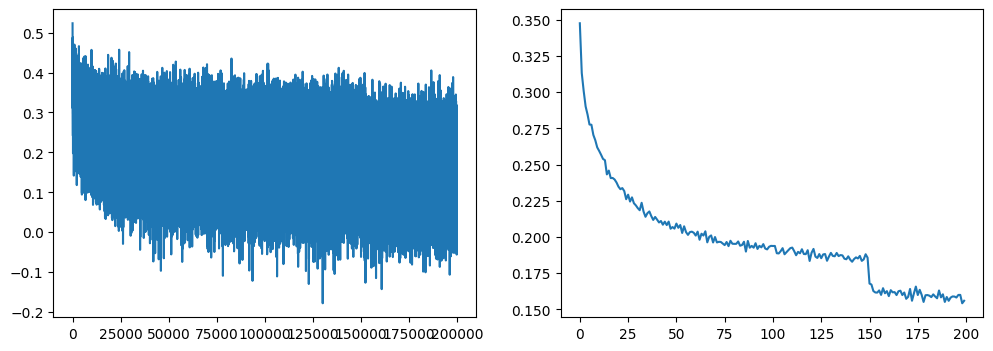

In [12]:
print(-torch.tensor(1 / 28).log())
# 32 batches are few... so you can get very lucky or unlucky

fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

ax[0].plot(torch.tensor(lossi))
ax[1].plot(torch.tensor(lossi).view(-1, 1000).mean(1))  # mean on each row


The second plot is much better, and we didn't change the data!
Something happened in the step, it jumped on a lower state (i.e. it learned).

Now we want to evaluate.
We need to tell PyTorch that we're not in the training phase anymore.
**BE CAREFUL**, or you'll get weird results due to batch normalization, which for us is a black box.

In [13]:
# put layers into eval mode (needed for batchnorm especially)
for layer in layers:
    layer.training = False


In [14]:
# evaluate the loss
@torch.no_grad()  # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x]  # embed the characters into vectors (N, block_size)
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)  # loss function
    print(split, loss.item())


split_loss("train")
split_loss("val")


train 1.3725385665893555
val 1.7553908824920654


In [15]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[
            torch.tensor([context])
        ]  # embed the characters into vectors (N,block_size)
        x = emb.view(emb.shape[0], -1)  # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print("".join(itos[i] for i in out))  # decode and print the generated word


amode.
leandro.
alfisio.
fabbions.
amperia.
oreino.
silvina.
wantie.
olderiza.
orea.
consolita.
mariacrostelfino.
emerande.
giandamaro.
fiero.
slorena-gettto.
morino.
morietta.
alcidisso.
artemine.


In [16]:
# we can do better and use "Embedding" (as pytorch) to see C as a first layer


# original network https://jmlr.org/papers/volume3/tmp/bengio03a.pdf

n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

# C= torch.randn(vocab_size,n_embd)
layers = [
    Embedding(vocab_size, n_embd),
    Flatten(block_size),
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
]

# parameter initialization

with torch.no_grad():
    layers[-1].weight *= 0.1  # last layer make less confident

# parameters=[C]+[p for layer in layers for p in layer.parameters()]
parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True


22308


In PyTorch one can write this as a sequential list of layer, with the same function names.

In [17]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

model = nn.Sequential(
    nn.Embedding(vocab_size, n_embd),
    nn.Flatten(block_size),
    nn.Linear(n_embd * block_size, n_hidden, bias=False),
    nn.BatchNorm1d(n_hidden),
    nn.Tanh(),
    nn.Linear(n_hidden, vocab_size),
)

# number of parameters in total
print(sum(p.nelement() for p in model.parameters()))
for p in model.parameters():
    p.requires_grad = True


22308


In [18]:
# or with 'karpathy' definitions...

n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

model = Sequential(
    [
        Embedding(vocab_size, n_embd),
        Flatten(block_size),
        Linear(n_embd * block_size, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        Linear(n_hidden, vocab_size),
    ]
)

# number of parameters in total
print(sum(p.nelement() for p in model.parameters()))
for p in model.parameters():
    p.requires_grad = True


22308


In [19]:
# put layers into eval mode (needed for batchnorm especially)
# be back on this now keep it !!

for layer in model.layers:
    layer.training = True

# model.train(True)


In [20]:
# same optimization as before time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    #   emb=C[Xb] # embed the characters into vectors
    #   x=emb.view(emb.shape[0],-1) #concatenate the vectors
    #   for layer in layers:
    #     x=layer(x)

    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in model.parameters():
        p.grad = None

    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in model.parameters():
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
# break


      0/ 200000: 3.5427
  10000/ 200000: 1.6889
  20000/ 200000: 1.7099
  30000/ 200000: 1.7663
  40000/ 200000: 1.6661
  50000/ 200000: 1.5461
  60000/ 200000: 1.8788
  70000/ 200000: 1.7811
  80000/ 200000: 1.9472
  90000/ 200000: 1.3643
 100000/ 200000: 1.5458
 110000/ 200000: 1.4089
 120000/ 200000: 1.6715
 130000/ 200000: 2.0241
 140000/ 200000: 1.6338
 150000/ 200000: 1.5033
 160000/ 200000: 1.5036
 170000/ 200000: 1.5975
 180000/ 200000: 1.3502
 190000/ 200000: 1.6590


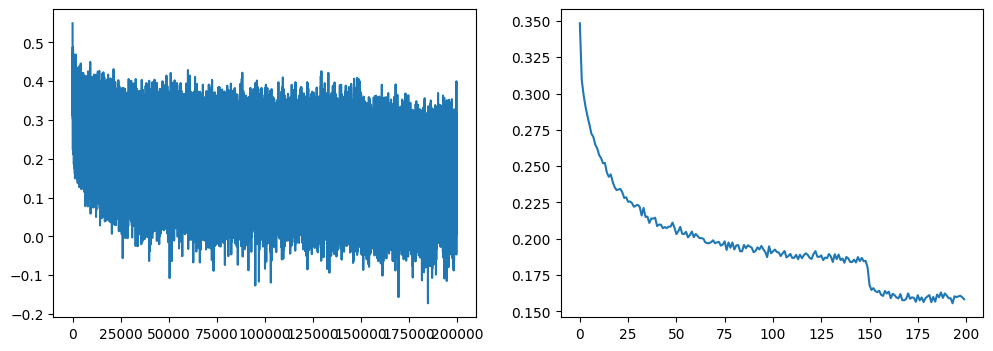

In [21]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

ax[0].plot(torch.tensor(lossi))
ax[1].plot(torch.tensor(lossi).view(-1, 1000).mean(1))  # mean on each row


In [22]:
# put layers into eval mode (needed for batchnorm especially)
# be back on this now keep it !!

for layer in model.layers:
    layer.training = False

# model.train(True)


In [23]:
# evaluate the loss
@torch.no_grad()  # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    #   emb=C[x] # embed the characters into vectors (N,block_size) before
    #   x=emb.view(emb.shape[0],-1) #concatenate the vectors

    #     for layer in layers:
    #         x=layer(x)

    logits = model(x)

    loss = F.cross_entropy(logits, y)  # loss function

    print(split, loss.item())


split_loss("train")
split_loss("val")


train 1.3757604360580444
val 1.73955237865448


In [24]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass the neural net
        #         emb=C[torch.tensor([context])] # embed the characters into vectors (N,block_size)
        #         x=emb.view(emb.shape[0],-1) #concatenate the vectors
        #         for layer in layers:
        #             x=layer(x)
        #         logits = x
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print("".join(itos[i] for i in out))  # decode and print the generated word


tima.
andrea.
laurezio.
loriela.
anio.
lucido.
eriscondo.
guerriana.
ginepro.
umbra.
angeloce.
raffoso.
marziano.
erlene.
bonulana.
eva.
abelda.
riziaddino.
calaria.
eride.


In [25]:
# now we are going to try to do better...but because we crunch all the characters at the first  layer (show picture language model),
# adding deeper layer will not be useful...we need first to do as wavenet: cluster characters in steps, hierarchialy...(convolution)
# Progressive fusion along the layers: 2-gram -> 4->gram -> 8-gram....show picture in wavenet paper.....

# first recreate the data set with block_size = 8


In [26]:
# let's look at a batch of just 4 example
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
print(Xb)


torch.Size([4, 8])
tensor([[ 0,  0,  0,  0,  7, 10, 15,  2],
        [ 0,  8,  2,  3, 19, 10,  6, 13],
        [ 0,  0,  0,  0,  0,  0,  0,  8],
        [10, 23,  2, 13,  5, 10, 15, 16]])


In [27]:
print(model.layers[0].out.shape)  # output of the embedding layer
print(model.layers[1].out.shape)  # output of the Flatten layer
print(model.layers[2].out.shape)  # output of the Linear layer


torch.Size([4, 8, 10])
torch.Size([4, 80])
torch.Size([4, 200])


Now multiply each vector for the matrix and take a 200dim vector as output

In [28]:
# now a nice surprise about the Linear Layer https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear

# just to look at the dimensions

(
    torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)
).shape  # broadcasting in the last term....


torch.Size([4, 200])

We can also add more dimensions... and PyTorch will work on the right dimension.

In [29]:
# but also !!
print((torch.randn(4, 2, 80) @ torch.randn(80, 200) + torch.randn(200)).shape)
# or also !!
print((torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape)


torch.Size([4, 2, 200])
torch.Size([4, 4, 200])


Instead of one vector of 80 we can use four vectors of 20.

In [30]:
# 1 2 3 4 5 6 7 8 -> (1 2) (3 4) (5 6) (7 8)
# we want to fuse vectors in pairs and acts in parallel on the 4 pairs of characters.
# i.e. we go from (torch.randn(4,80)@ torch.randn(80,200)+torch.randn(200)).shape
# ....second batch dimension...discuss in class...!!

print((torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape)


torch.Size([4, 4, 200])


In [31]:
# so now we need to change the Flatten layer to produce a (4,4,20) tensor and NOT (4,80)
e = torch.randn(
    4, 8, 10
)  # goal: want this to be (4,4,20) where consecutive 10-d vectors
# get concatenated (in pairs (1 2) (3 4) (5 6) (7 8))


In [32]:
# trick

print(list(range(10)))
print(list(range(10))[::2])
print(list(range(10))[1::2])


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 2, 4, 6, 8]
[1, 3, 5, 7, 9]


In [33]:
# so we want this...
print(e.shape)
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
print(explicit.shape)


torch.Size([4, 8, 10])
torch.Size([4, 4, 20])


In [34]:
# but ALSO this works !!

# (e.view(4, 4, 20) == explicit)  # .all()   try this...


In [35]:
input = torch.randn(4, 8, 10)
print(input.shape)
m = nn.Flatten()
output = m(input)
print(output.shape)


torch.Size([4, 8, 10])
torch.Size([4, 80])


In [36]:
# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []


In [37]:
# Back to the Model...here we recover the previous one with FlattenConsecutive(block_size)


n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

# model = nn.Sequential(
#     nn.Embedding(vocab_size, n_embd),nn.Flatten(), nn.Linear(n_embd * block_size, n_hidden, bias=False),
#     nn.BatchNorm1d(n_hidden), nn.Tanh(),
#     nn.Linear(n_hidden, vocab_size))

model = Sequential(
    [
        Embedding(vocab_size, n_embd),
        FlattenConsecutive(block_size),
        Linear(n_embd * block_size, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        nn.Tanh(),
        Linear(n_hidden, vocab_size),
    ]
)


# parameter init


# with torch.no_grad()
#    layers=model.layers()
#    layers[-1].weight *= 0.1 # last layer make less confident # fix this !!

# parameters=[C]+[p for layer in layers for p in layer.parameters()]  before

# number of parameters in total
print(sum(p.nelement() for p in model.parameters()))
for p in model.parameters():
    p.requires_grad = True


22308


In [38]:
# let's look at a batch of just 4 example
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
print(Xb)


torch.Size([4, 8])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  4],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, 16, 13, 10, 23]])


In [39]:
for layer in model.layers[:-2]:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))


Embedding : (4, 8, 10)
FlattenConsecutive : (4, 80)
Linear : (4, 200)
BatchNorm1d : (4, 200)


In [40]:
# we now move to a hierarchical approach

n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

model = Sequential(
    [
        Embedding(vocab_size, n_embd),
        FlattenConsecutive(2),
        Linear(n_embd * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(n_hidden * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(n_hidden * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        Linear(n_hidden, vocab_size),
    ]
)


# number of parameters in total
print(sum(p.nelement() for p in model.parameters()))
for p in model.parameters():
    p.requires_grad = True


171108


In [41]:
# let's look at a batch of just 4 example
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
print(Xb)


torch.Size([4, 8])
tensor([[ 0,  0,  0,  0,  0, 14,  2, 19],
        [ 0,  0,  0,  0,  0,  0,  0,  8],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  8, 22, 20, 21,  2]])


In [42]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))


Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 28)


In [43]:
print(logits.shape)


torch.Size([4, 28])


In [44]:
# we now move to a hierarchical approach but resize to compare with the initial onwe
# we use n_hidden=68 to have almost the same number of parameters..,

n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

model = Sequential(
    [
        Embedding(vocab_size, n_embd),
        FlattenConsecutive(2),
        Linear(n_embd * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(n_hidden * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(n_hidden * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        Linear(n_hidden, vocab_size),
    ]
)


# number of parameters in total
print(sum(p.nelement() for p in model.parameters()))
for p in model.parameters():
    p.requires_grad = True


171108


In [45]:
# same optimization as before
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass

    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass

    for p in model.parameters():
        p.grad = None

    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in model.parameters():
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
# break


      0/ 200000: 3.6123
  10000/ 200000: 1.8124
  20000/ 200000: 1.6373
  30000/ 200000: 1.7834
  40000/ 200000: 1.2532
  50000/ 200000: 1.8544
  60000/ 200000: 1.0383
  70000/ 200000: 1.5017
  80000/ 200000: 1.0546
  90000/ 200000: 1.0752
 100000/ 200000: 1.4752
 110000/ 200000: 1.1615
 120000/ 200000: 1.2915
 130000/ 200000: 1.1062
 140000/ 200000: 1.1331
 150000/ 200000: 1.4284
 160000/ 200000: 1.9482
 170000/ 200000: 1.2848
 180000/ 200000: 1.2159
 190000/ 200000: 1.3101


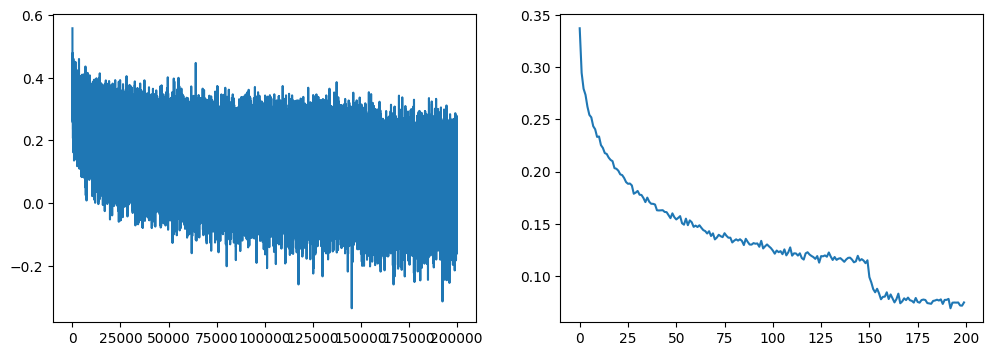

In [46]:


fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

ax[0].plot(torch.tensor(lossi))
ax[1].plot(torch.tensor(lossi).view(-1, 1000).mean(1))  # mean on each row


In [47]:
# put layers into eval mode (needed for batchnorm especially)...comment in class !
for layer in model.layers:
    layer.training = False


In [48]:
# evaluate the loss
@torch.no_grad()  # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    logits = model(x)

    loss = F.cross_entropy(logits, y)  # loss function

    print(split, loss.item())


split_loss("train")
split_loss("val")


train 1.1616768836975098
val 1.8372830152511597


In [49]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print("".join(itos[i] for i in out))  # decode and print the generated word


gaspawa.
waldemaro.
ambra.
aida.
eraldina.
isacco.
amadio.
mariso.
fabrina.
valdimaro.
gerarda.
opaldo.
firmanina.
melchiorino.
nicoletto.
lallo.
giommato.
callisto.
sostino.
cleontina.
